This notebook implements a number of nearest neighbour algorithm for the regression task

In [27]:
# Standard Python Imports
import os
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace


# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import copy

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LinearRegression


In [18]:
args = Namespace(
   seed=5059 
)  

In [19]:
rng = np.random.default_rng(args.seed)

# 1 Load in Data

In [1]:
dataDir = "NumpyData/"

In [11]:
X_train_processed = np.load(dataDir + 'X_train_prepared.npy')
X_test_processed = np.load(dataDir + 'X_test_prepared.npy')
X_val_processed = np.load(dataDir + 'X_val_prepared.npy')

y_train_processed = np.load(dataDir + 'y_train_prepared.npy')
y_test_processed = np.load(dataDir + 'y_test_prepared.npy')
y_val_processed = np.load(dataDir + 'y_val_prepared.npy')

y_train = np.load(dataDir + 'y_train.npy')
y_val = np.load(dataDir + 'y_val.npy')
y_test = np.load(dataDir + 'y_test.npy')

Combine val and train - val not needed for K-means

In [12]:
X_train_processed =  np.vstack((X_train_processed, X_val_processed))
y_train_processed =  np.vstack((y_train_processed, y_val_processed))
y_train = np.concatenate((y_train, y_val))

# 2 First Principles K-Means

In [15]:
def cosine_similarity(A, B):
    '''
        Cosine similarity distance function
        @param (A) ; n-dimensional vector (numpy array)
        @param (B) : n-dimensional vector (numpy array)
    '''

    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    return dot_product / (norm_A * norm_B)

In [16]:
def assign_step(data, us, K):
    ''' 
        K-mean assign-step (assign datapoints to clusters)
        @param (data) : the data matrix (n x d)
        @param (us)   : the cluster means (K x 1)
        @param (K)    : the number of clusters
    '''

    _, N = data.shape

    distances = np.array([[cosine_similarity(x, u) for u in us] for x in data])

    zs = np.eye(K)[np.argmax(distances, axis=1)]

    min_distances = np.sum(np.max(distances, axis=1))

    return min_distances,zs

In [17]:
def update_step(data, zs, K):
    ''' 
        K-mean update step (update cluster assignments of each datapoint)
        @param (data) : the data matrix (n x d)
        @param (zs)   : the datapoint assignments ()
        @param (K)    : the number of clusters
    '''

    _, d = data.shape

    combined = np.dot(data.T, zs).T
    sums = np.sum(zs, axis=0)

    for i in range(0,K):
        combined[i] *= 1/sums[i]

    return combined

In [22]:
def kmeans(data, K=10, tol= 1e-4, maxIters= 100):
    ''' 
        K-Means assign-update learning algorithm 
        @param (data) : the data matrix (n x d)
        @param (K) : the number of clusters to assume
        @param (tol) : the convergence check loss amount
        @param (maxIters) : maximum iterations to perform before stopping
    '''


    n, d = data.shape 

    init_us_ids = rng.integers(n, size = K)

    us = data[init_us_ids, :]

    zs = np.zeros(n)

    losses = []

    # loop until converge 
    for i in range(maxIters):
        # assignment step
        min_distances, zs = assign_step(data,us,K)
        
        # update step
        us = update_step(data,zs,K)

        # convergence check  
        losses.append(1 - min_distances)      

        if i > 1 and np.abs(losses[i] - losses[i-1]) < tol : break

    return losses, zs, us

In [23]:
def find_best_results(trials, X, K=10, tol=1e-4, maxIters=100):
    ''' 
        Runs a number of trials of kmeans to produce cluster assignments with the lowest loss

        @param (trials) : integer number of trials to run
        @param (X) : the data matrix
    '''

    best = np.inf
    l = None
    z = None
    u = None
    for i in range(0,trials):
        losses, zs, us = kmeans(X, K, tol, maxIters)
        mean_loss = np.mean(losses)
        if mean_loss < best:
            best = mean_loss
            l = losses
            z = zs
            u = us 

    return l, z, u

In [58]:
def predict(X_test, us, zs, y_train):
    # Normalize input vectors 
    X_test_norm = np.linalg.norm(X_test, axis=1, keepdims=True)
    X_test_normalized = X_test/X_test_norm
    # Normalize cluster means
    us_norm = np.linalg.norm(us, axis=1, keepdims=True)
    us_normalized = us / us_norm

    # Compute similarities 
    similarities = np.dot(X_test_normalized, us_normalized.T)

    # Compute assignments for test inputs
    pred_zs = np.argmax(similarities, axis=1)

    # compute sum of labels for train data, per cluster
    sums = np.dot(zs.T, y_train)

    # get number of train datapoints assigned per cluster
    counts = np.sum(zs, axis=0)

    # compute average
    means = sums/counts 

    # assign averages to test data predictions
    y_preds = means[pred_zs]

    return y_preds


In [52]:
losses, zs, us = find_best_results(1, X_train_processed, K=20)

In [53]:
y_preds = predict(X_test_processed, us, zs, y_train)

# 3 Evaluation

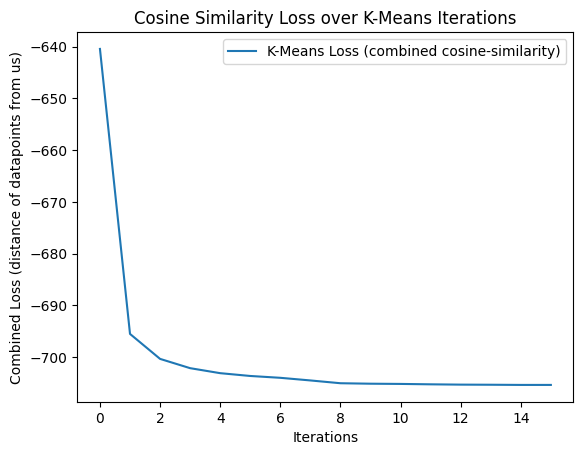

In [54]:
plt.plot(losses, label="K-Means Loss (combined cosine-similarity)")
plt.title("Cosine Similarity Loss over K-Means Iterations")
plt.xlabel("Iterations")
plt.ylabel("Combined Loss (distance of datapoints from us)")
plt.legend()
plt.show()

In [55]:
learned_labels = np.argmax(zs, axis=1)

In [56]:
spherical_kmeans_mse = np.sqrt(mean_squared_error(y_preds, y_test))

In [57]:
print("Spherical K-Means MSE : ", spherical_kmeans_mse)

Spherical K-Means MSE :  769.2883866281671


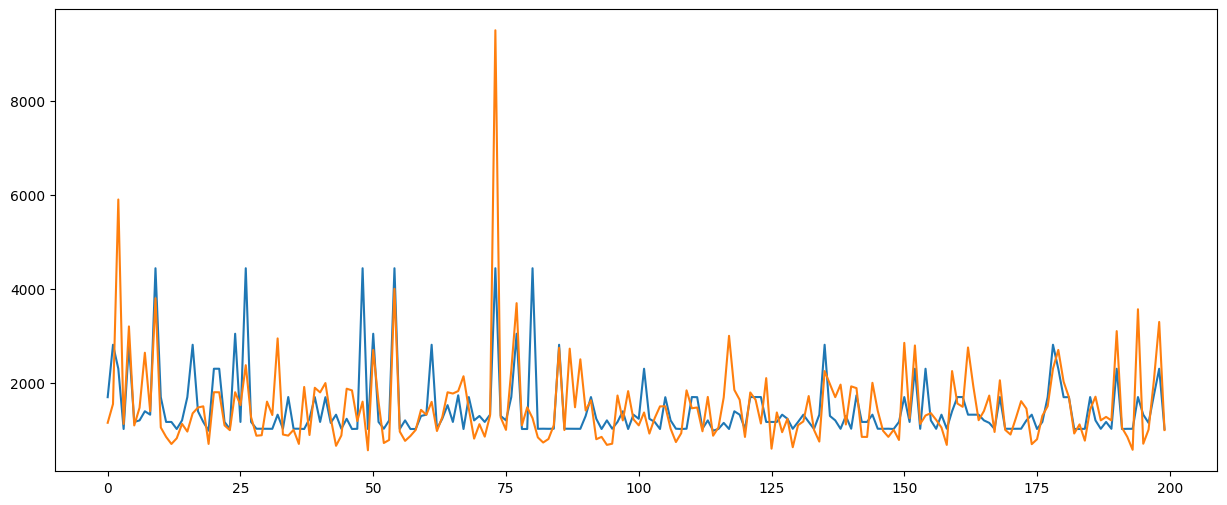

In [59]:
plt.figure(figsize=(15,6))

plt.plot([i for i in range(len(y_test))], y_preds)
plt.plot([i for i in range(len(y_test))], y_test)